# Load and plot data

In [1]:
!pip install yfinance

In [2]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM,Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import MinMaxScaler

import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime, timedelta,date

# GRU LSTM

Specify settings. Cyrpto to predict and LSTM sequence steps to use

In [3]:
CRYPTO = 'XLM'
TIME_STEPS = 50

## Load CSVs

Get data from Yahoo Finance and prepare a data frame

In [4]:
# Give columns descriptive names
def getColumnNames(names, columns):
  columnNames = ['Date']
  for currency in names:
    for column in columns:
      if column != 'Date':
        name = currency + "-" + column
        columnNames.append(name)
      else:
        continue
  return columnNames

# Get currency information from Yahoo and merge to single DF
def getData(currencies, start_date, end_date):
  columns = ['Date', 'Open', 'High', 'Low', 'Volume', 'Adj Close']
  columnNames = getColumnNames(currencies,columns)
  result = pdr.get_data_yahoo(currencies[0], start=start_date, end=end_date)
  result = result.reset_index()
  result = result[columns]
  for currency in currencies[1:]:
    df = pdr.get_data_yahoo(currency, start=start_date, end=end_date)
    df = df.reset_index()
    result = pd.merge(result, df[columns], how='inner', on='Date')
  result.columns = columnNames
  return result

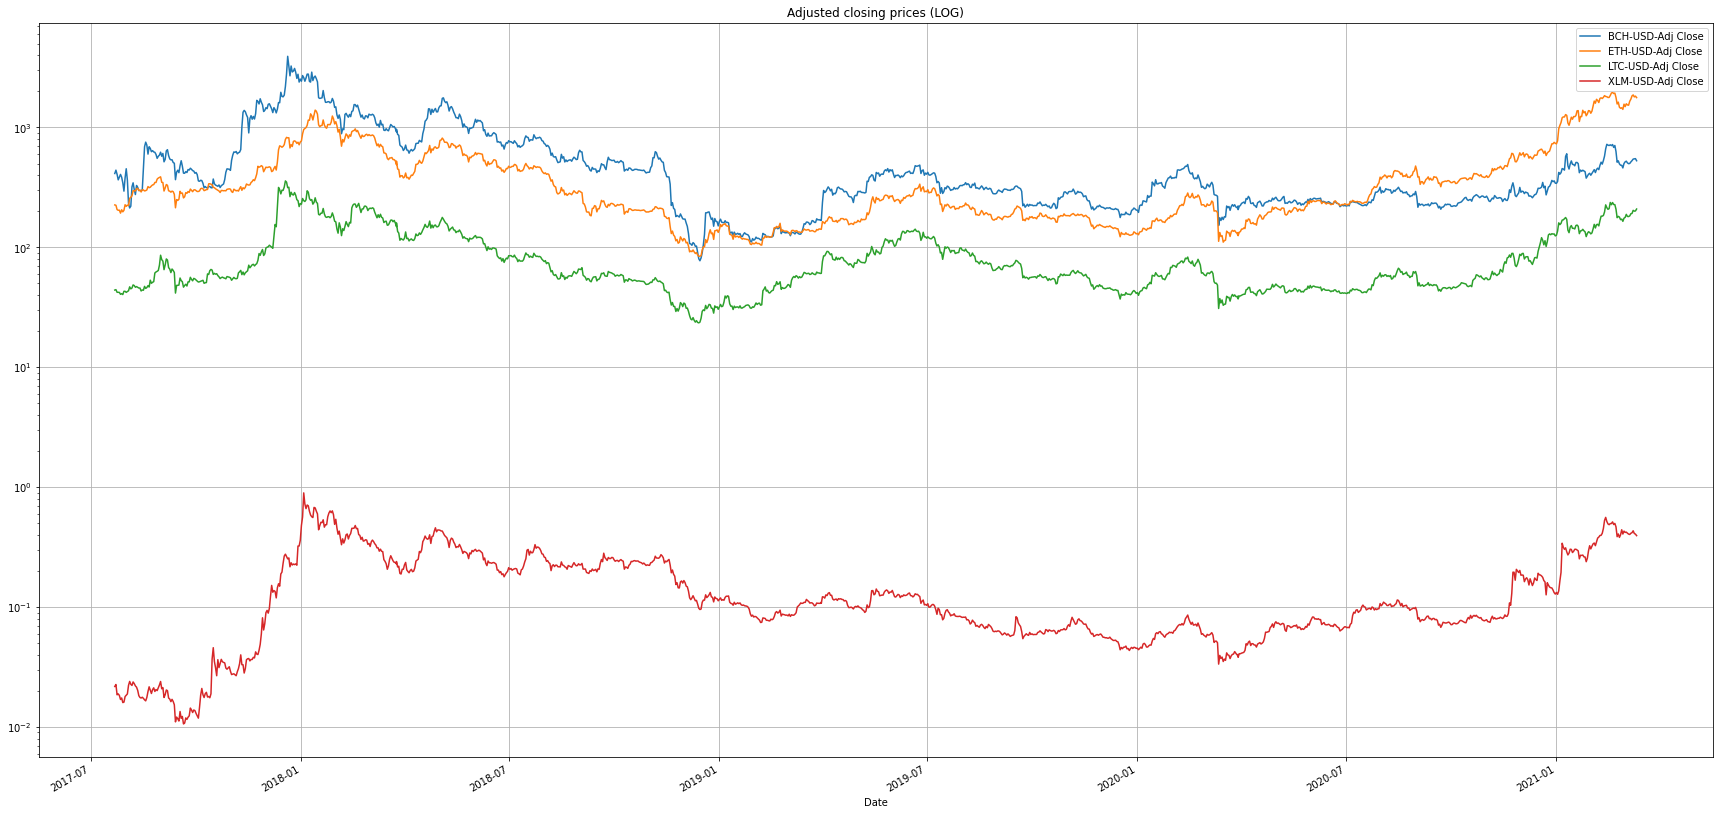

In [5]:
# Information used in the process
#currencies = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD', 'XLM-USD']
currencies = ['BCH-USD', 'ETH-USD', 'LTC-USD', 'XLM-USD']
if CRYPTO == "BTC":
  currencies.append("BTC-USD")
start_date = "2016-01-01"
end_date = date.today()

# Get data and plot
df = getData(currencies, start_date, end_date)
df = df.sort_values('Date')
df = df.dropna()
to_plot = [col for col in df.columns if '-Adj Close' in col]
fig = df.plot(x='Date', y=to_plot, figsize=(30,15), title='Adjusted closing prices (LOG)', logy=True, grid=True, )

## Prepare dataset for LSTM
Create train/test sets by dropping columns and scaling

In [6]:
# Shift 1 up (todays close -> tomorrows predictor) and drop last row
COLUMN = CRYPTO + "-USD-Adj Close"
df['TOMORROW_CLOSE'] = df[COLUMN].shift(-1,fill_value=0)
df.drop(df.tail(1).index,inplace=True)
df.tail()

,Date,BCH-USD-Open,BCH-USD-High,BCH-USD-Low,BCH-USD-Volume,BCH-USD-Adj Close,ETH-USD-Open,ETH-USD-High,ETH-USD-Low,ETH-USD-Volume,ETH-USD-Adj Close,LTC-USD-Open,LTC-USD-High,LTC-USD-Low,LTC-USD-Volume,LTC-USD-Adj Close,XLM-USD-Open,XLM-USD-High,XLM-USD-Low,XLM-USD-Volume,XLM-USD-Adj Close,TOMORROW_CLOSE
1361,2021-03-07,501.228821,517.914001,500.797668,2.256359e+09,516.173523,1655.392456,1730.924194,1636.564453,2.380994e+10,1723.153809,182.990692,191.770233,182.422348,3.541358e+09,190.759109,0.403360,0.421909,0.403360,7.962404e+08,0.412844,0.417532
1362,2021-03-08,516.181824,528.996887,502.262756,2.792448e+09,528.996887,1724.229248,1835.192139,1670.942017,2.763099e+10,1834.727905,190.771271,194.619186,180.068420,4.401225e+09,191.927689,0.412990,0.420215,0.403189,8.570743e+08,0.417532,0.432650
1363,2021-03-09,529.013489,546.526184,524.487976,2.777425e+09,545.026001,1835.148071,1868.048828,1804.266357,2.346124e+10,1868.048828,191.940048,204.750626,189.419708,5.408295e+09,203.637863,0.417489,0.433775,0.412946,1.048814e+09,0.432650,0.410769
1364,2021-03-10,545.029968,566.941589,519.540100,3.942104e+09,546.839600,1868.489014,1873.803223,1766.490479,2.515417e+10,1799.166260,203.641586,207.392395,192.582458,6.296083e+09,200.516861,0.432330,0.432621,0.407995,9.754854e+08,0.410769,0.405900
1365,2021-03-11,546.696777,562.515198,532.015564,4.102967e+09,549.783203,1798.033936,1843.818848,1734.617065,2.401313e+10,1826.194946,200.449753,203.167831,191.536835,4.823155e+09,201.250336,0.410388,0.412951,0.397844,9.520211e+08,0.405900,0.394333


create train/test
TODO: Now all recent data is in test set. Swap? Maybe recent data in test set

In [7]:
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size],df.iloc[train_size:]

Dimension of train data:  (1092, 22)
Dimension of test data:  (274, 22)


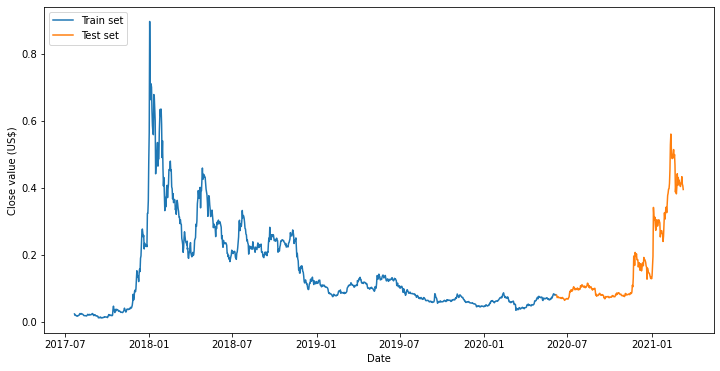

In [8]:
# Plot train and test data
plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(train_dataset.Date, train_dataset.TOMORROW_CLOSE)
plt.plot(test_dataset.Date, test_dataset.TOMORROW_CLOSE)
plt.xlabel('Date')
plt.ylabel('Close value (US$)')
plt.legend(['Train set', 'Test set'], loc='upper left')
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [9]:
# Split train data to X and y
X_train = train_dataset.drop(['TOMORROW_CLOSE', 'Date'], axis = 1)
y_train = train_dataset.loc[:,['TOMORROW_CLOSE']]
# Split test data to X and y
X_test = test_dataset.drop(['TOMORROW_CLOSE', 'Date'], axis = 1)
y_test = test_dataset.loc[:,['TOMORROW_CLOSE']]


In [10]:
# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (-1,1))
scaler_y = MinMaxScaler(feature_range = (-1,1))
# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)
# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)
# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

X_train.shape:  (224, 50, 20)
y_train.shape:  (1042, 1)
X_test.shape:  (224, 50, 20)
y_test.shape:  (1042, 1)


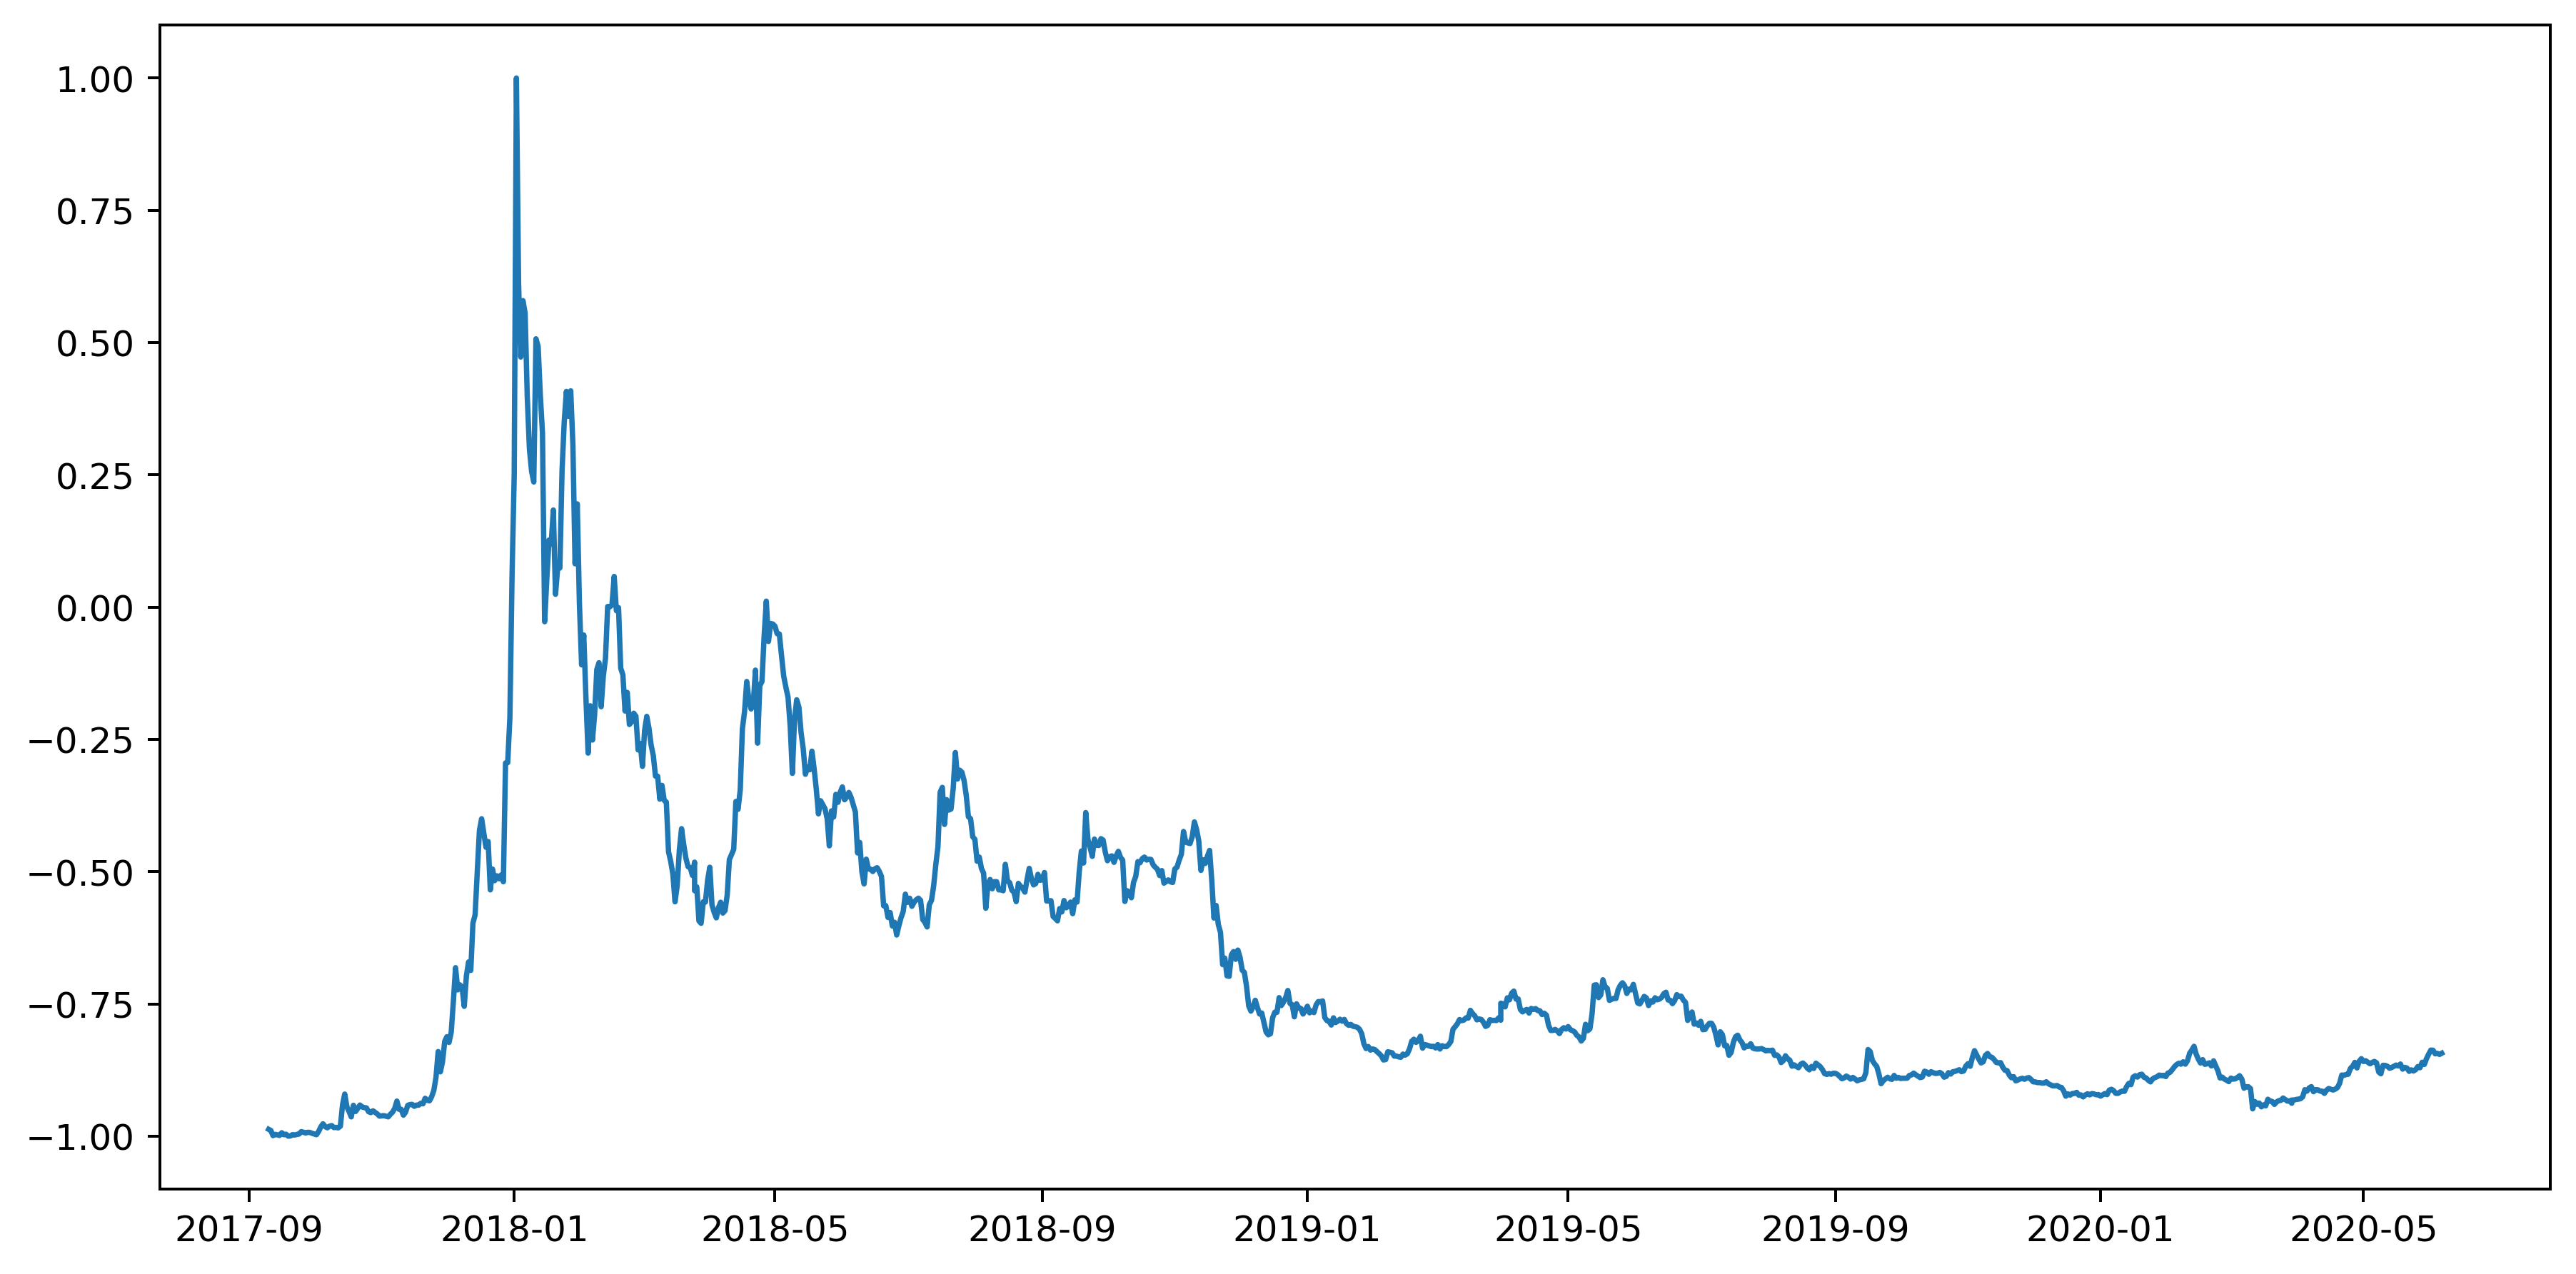

In [11]:
def threeD_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)

X_test, y_test = threeD_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = threeD_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape)

plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(train_dataset.Date[TIME_STEPS:], y_train)

## Define LSTM

In [12]:
# Create model
def create_model(units):
    model = Sequential()
    # First layer of LSTM
    model.add(GRU (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Second layer of LSTM
    model.add(GRU (units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

## Train

In [13]:
# Fit Model
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

    # shuffle = False because the order of the data matters!
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

# GRU LSTM 
model = create_model(64)
history = fit_model(model)

Epoch 1/100
27/27 [==============================] - 12s 325ms/step - loss: 0.0681 - val_loss: 0.0025
Epoch 2/100
27/27 [==============================] - 8s 297ms/step - loss: 0.0885 - val_loss: 0.0257
Epoch 3/100
27/27 [==============================] - 7s 275ms/step - loss: 0.0315 - val_loss: 0.0019
Epoch 4/100
27/27 [==============================] - 8s 301ms/step - loss: 0.0299 - val_loss: 0.0083
Epoch 5/100
27/27 [==============================] - 8s 295ms/step - loss: 0.0385 - val_loss: 0.0051
Epoch 6/100
27/27 [==============================] - 8s 292ms/step - loss: 0.0326 - val_loss: 0.0136
Epoch 7/100
27/27 [==============================] - 8s 285ms/step - loss: 0.0503 - val_loss: 0.0050
Epoch 8/100
27/27 [==============================] - 8s 293ms/step - loss: 0.0374 - val_loss: 0.0078
Epoch 9/100
27/27 [==============================] - 8s 295ms/step - loss: 0.0485 - val_loss: 0.0105
Epoch 10/100
27/27 [==============================] - 8s 294ms/step - loss: 0.0367 - val_l

## Plot training process

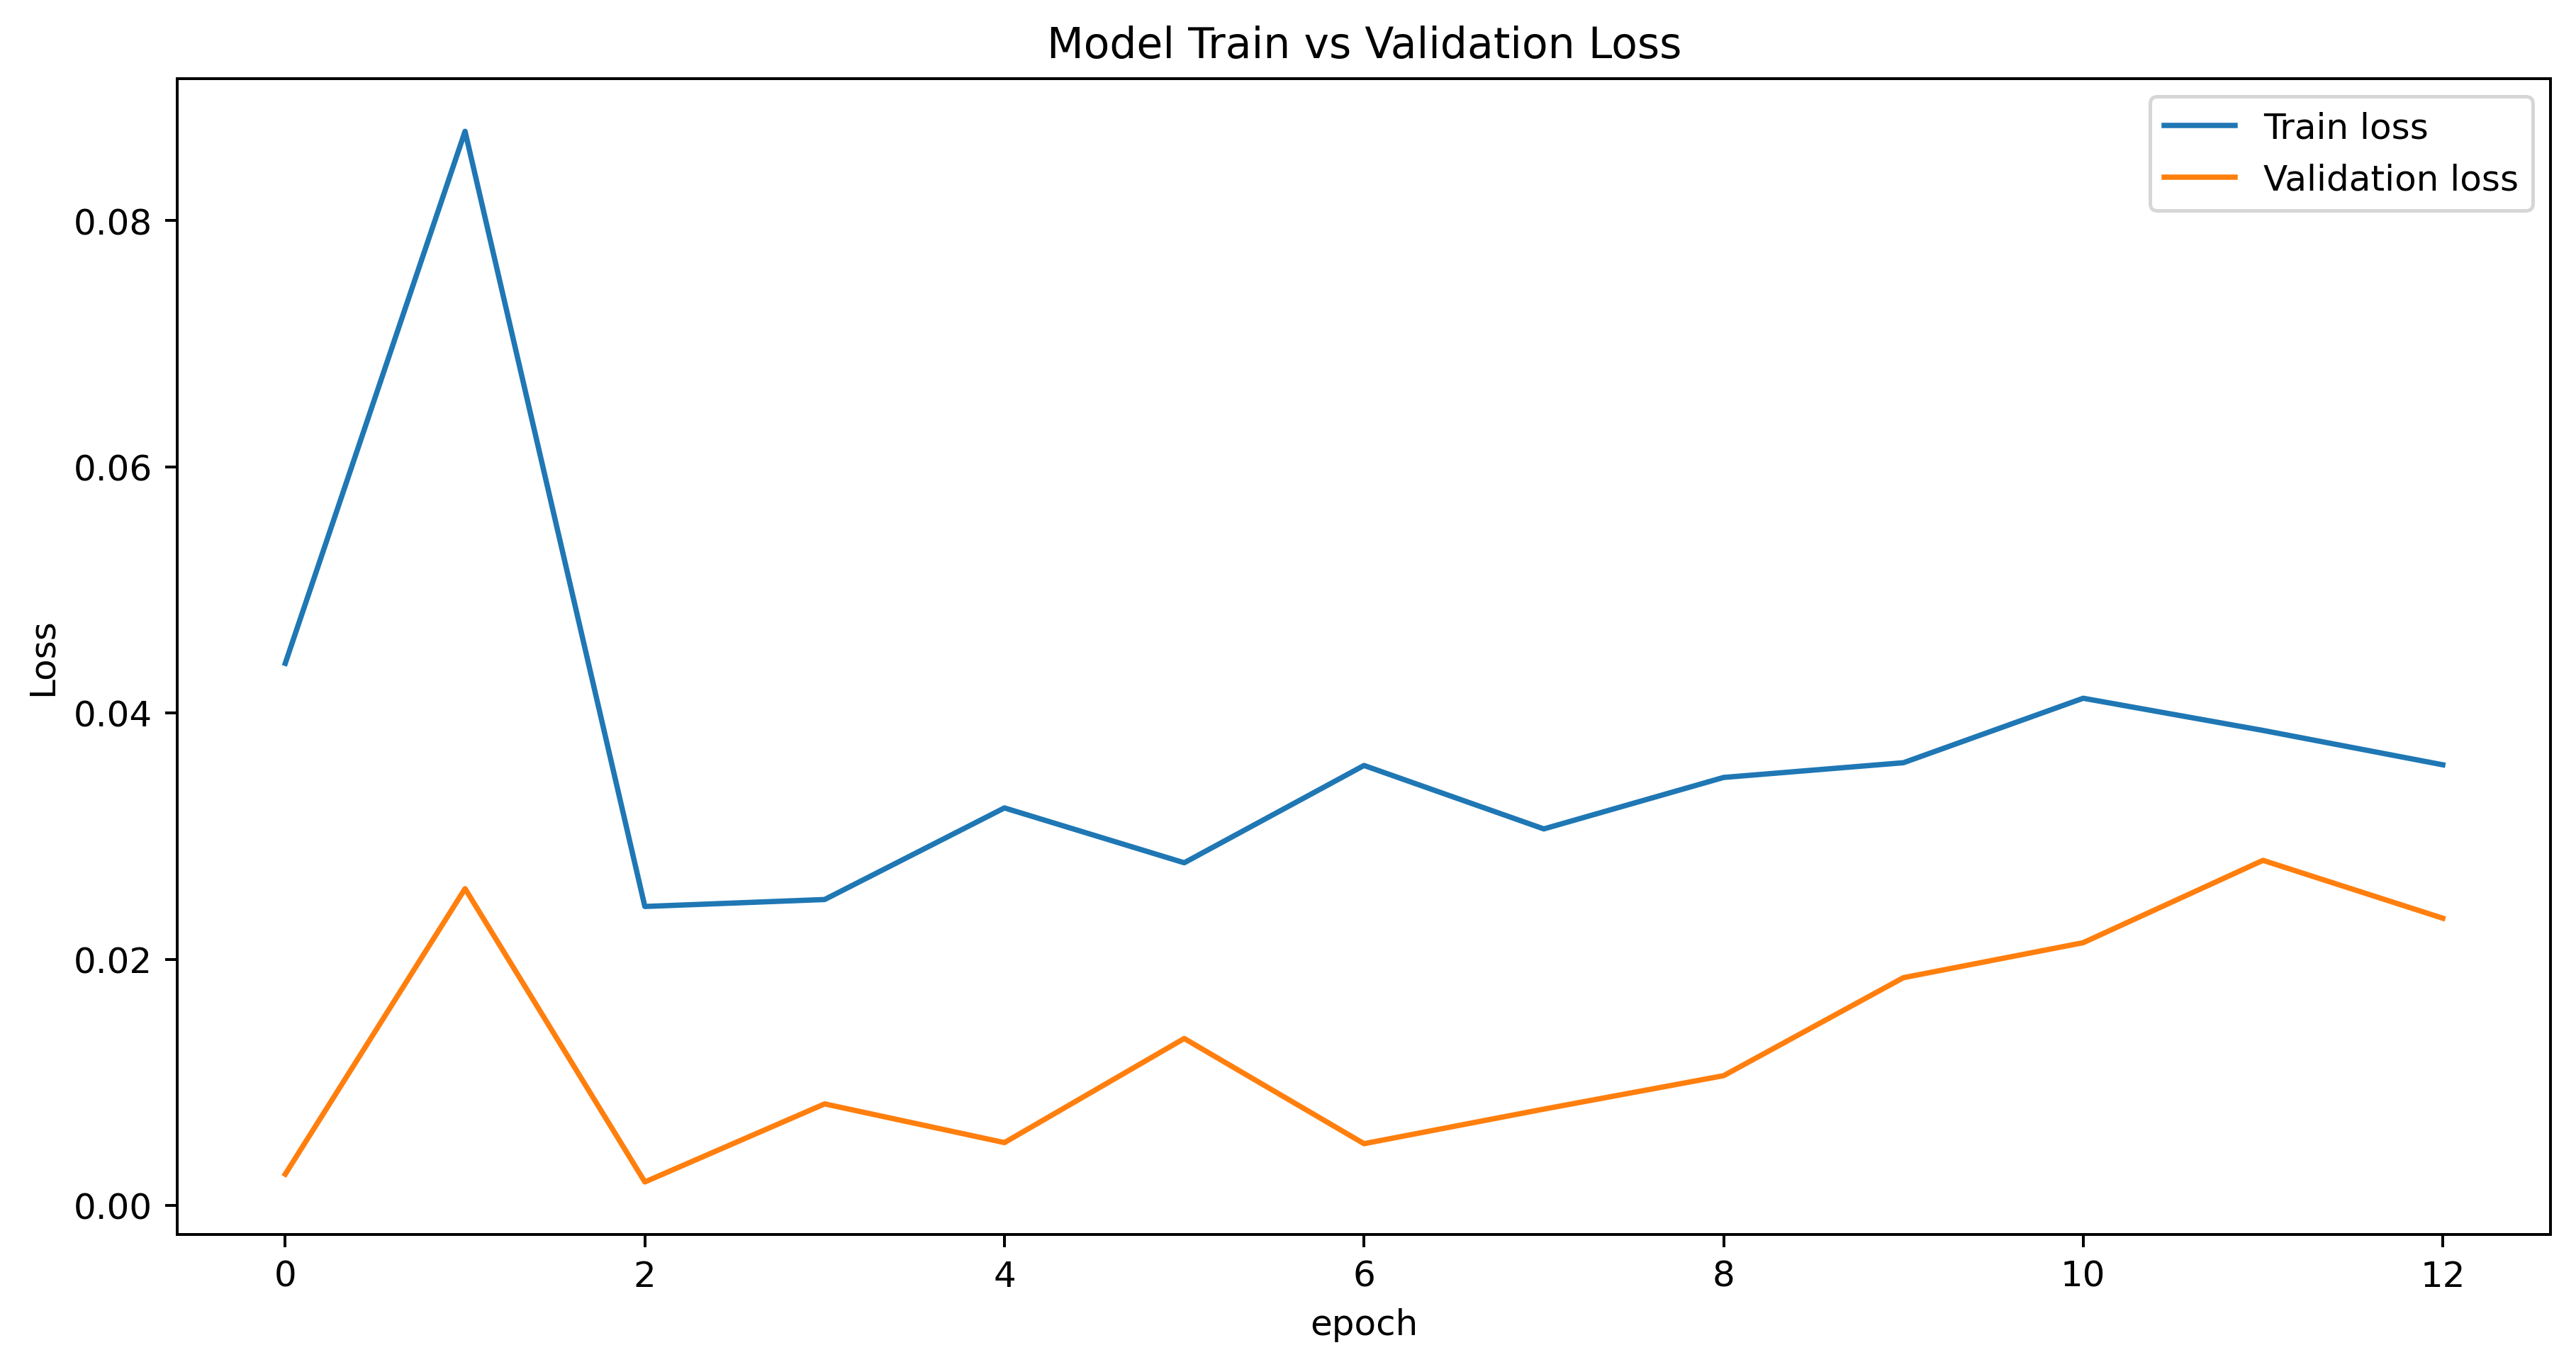

In [14]:
plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    

## Predict

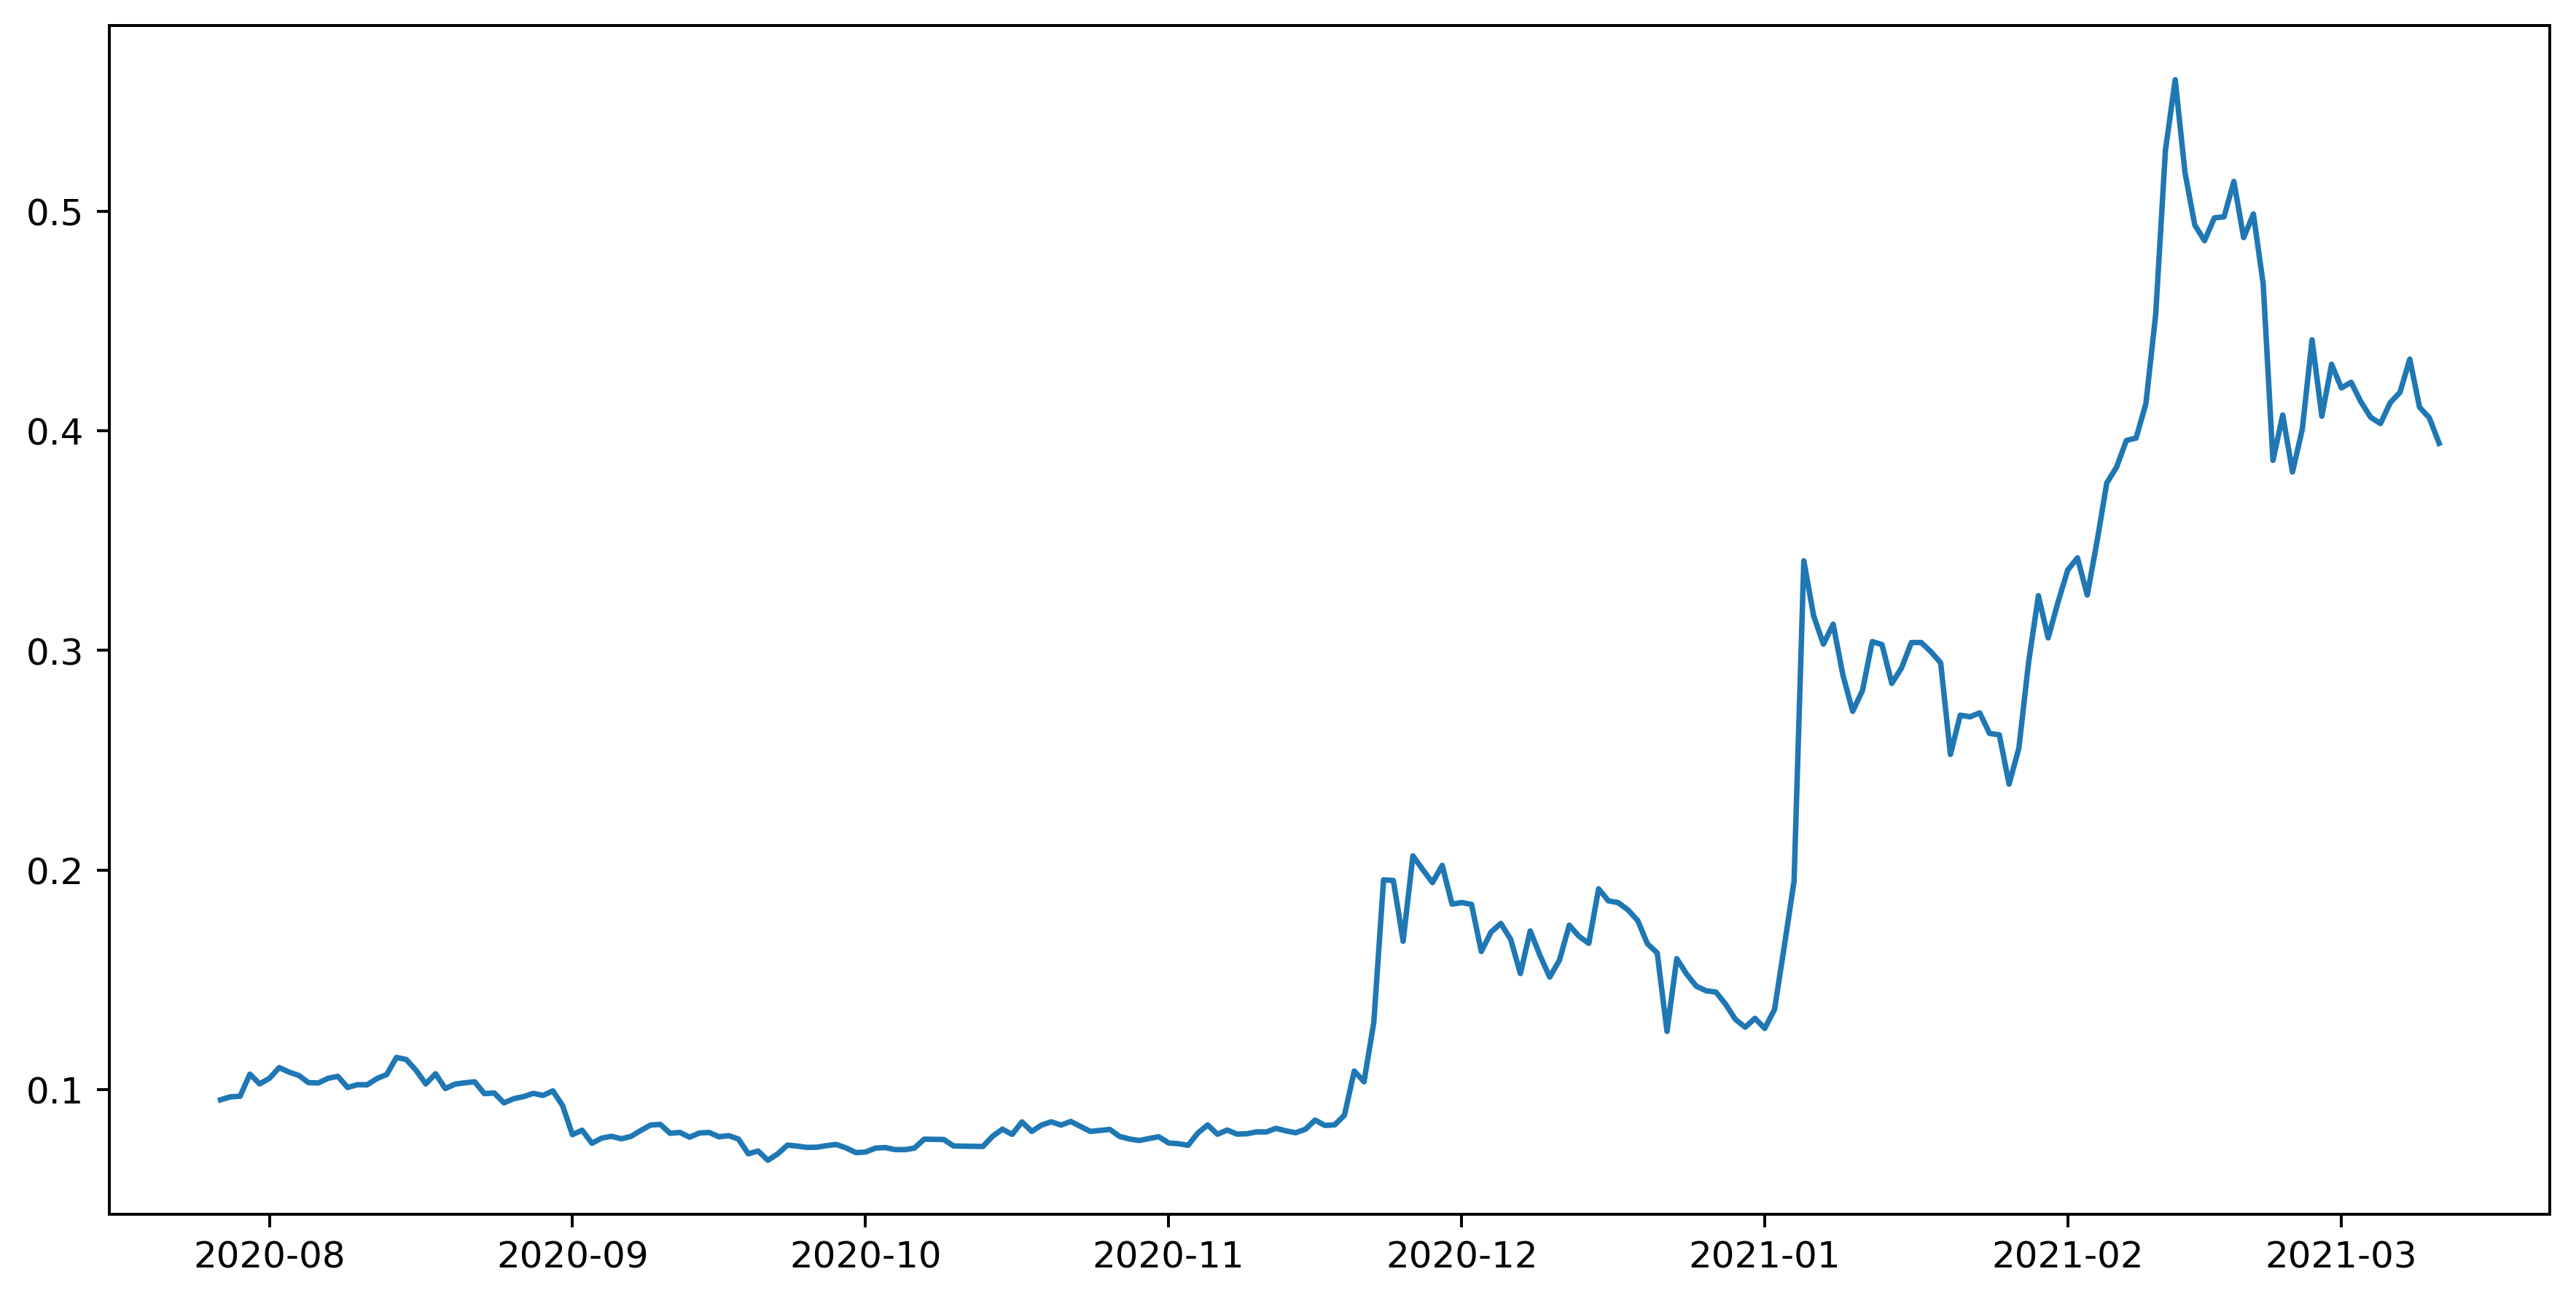

In [15]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
plt.plot(test_dataset.Date[TIME_STEPS:],y_test)


In [16]:
prediction_unscaled = model.predict(X_test)
prediction = scaler_y.inverse_transform(prediction_unscaled)

Text(0, 0.5, 'Close value ($)')

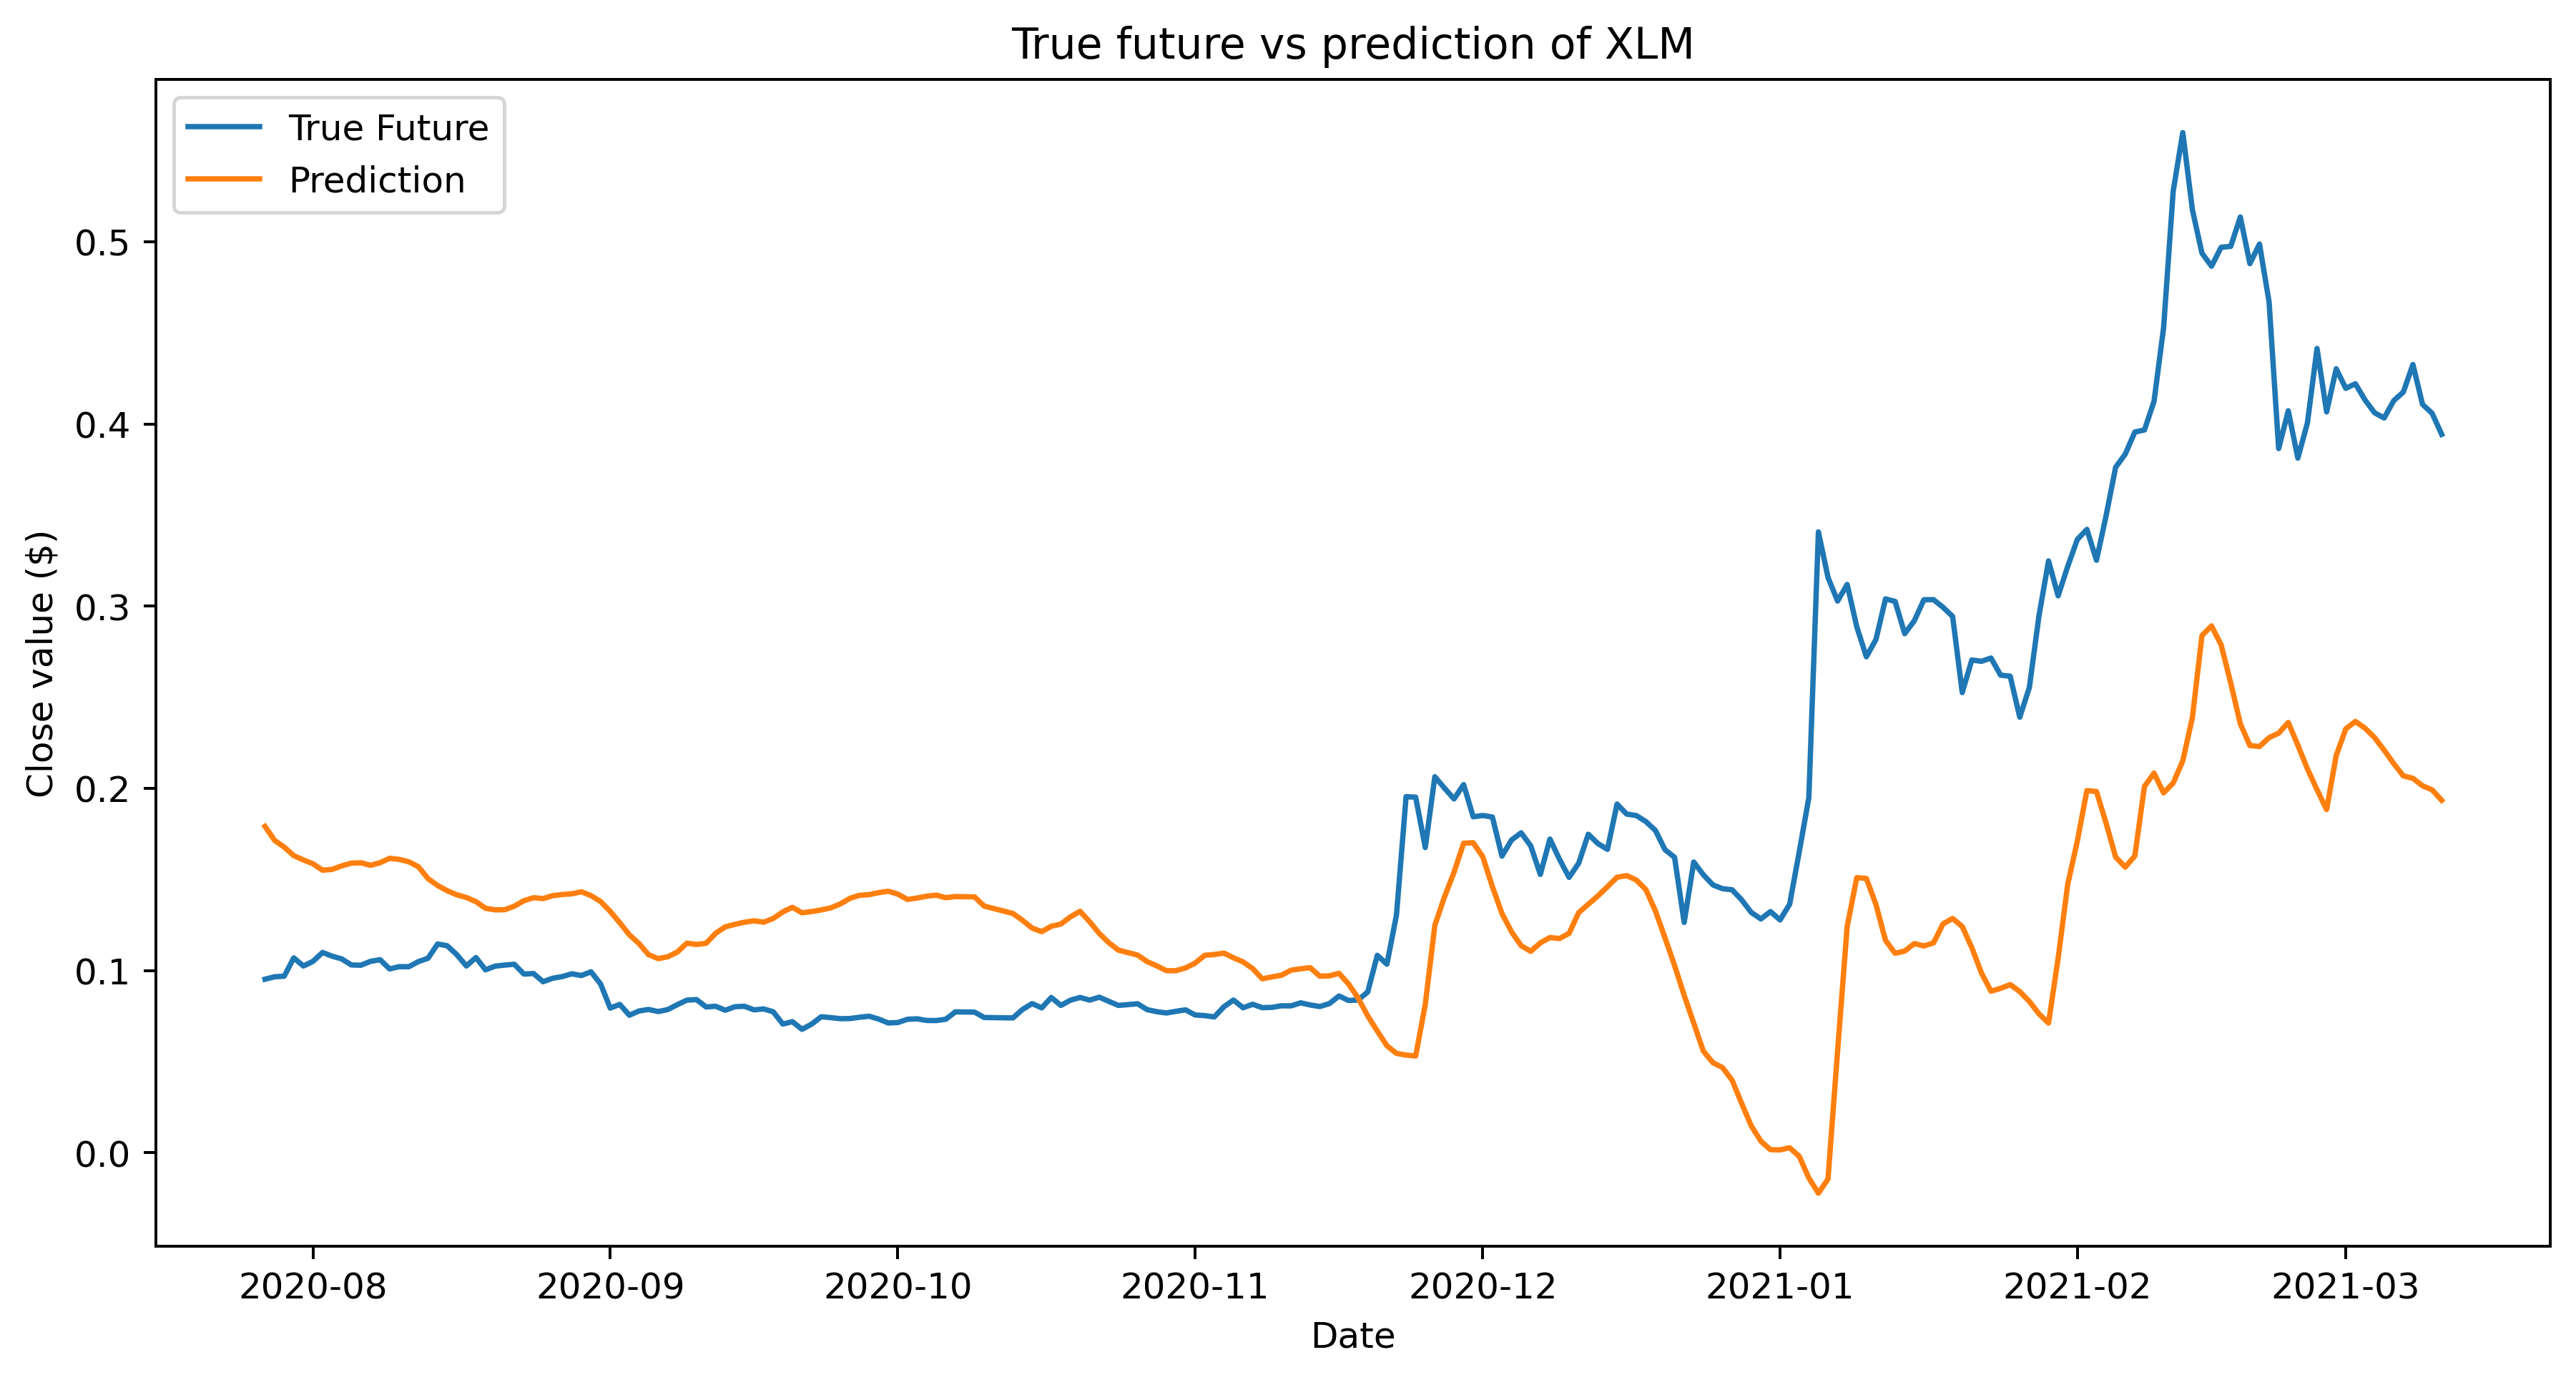

In [17]:
plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360
range_future = len(prediction)

plt.plot(test_dataset.Date[TIME_STEPS:], np.array(y_test), label='True Future')
plt.plot(test_dataset.Date[TIME_STEPS:], np.array(prediction),label='Prediction')

plt.title('True future vs prediction of ' + CRYPTO)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Close value ($)')

## Forecasting Predict Next Day

In [18]:
def forecast(X_input, time_steps):

  # Scale the forecast input with the scaler fit on the training data
  X = input_scaler.transform(X_input)

  # Reshape forecast data as 3D input
  Xs = []
  for i in range(len(X) - time_steps):
      v = X[i:i+time_steps, :]
      Xs.append(v)
   
  X_transformed = np.array(Xs)
  # Make prediction for forecast data using GRU model 
  prediction = model.predict(X_transformed)
  prediction_actual = scaler_y.inverse_transform(prediction)
  return prediction_actual


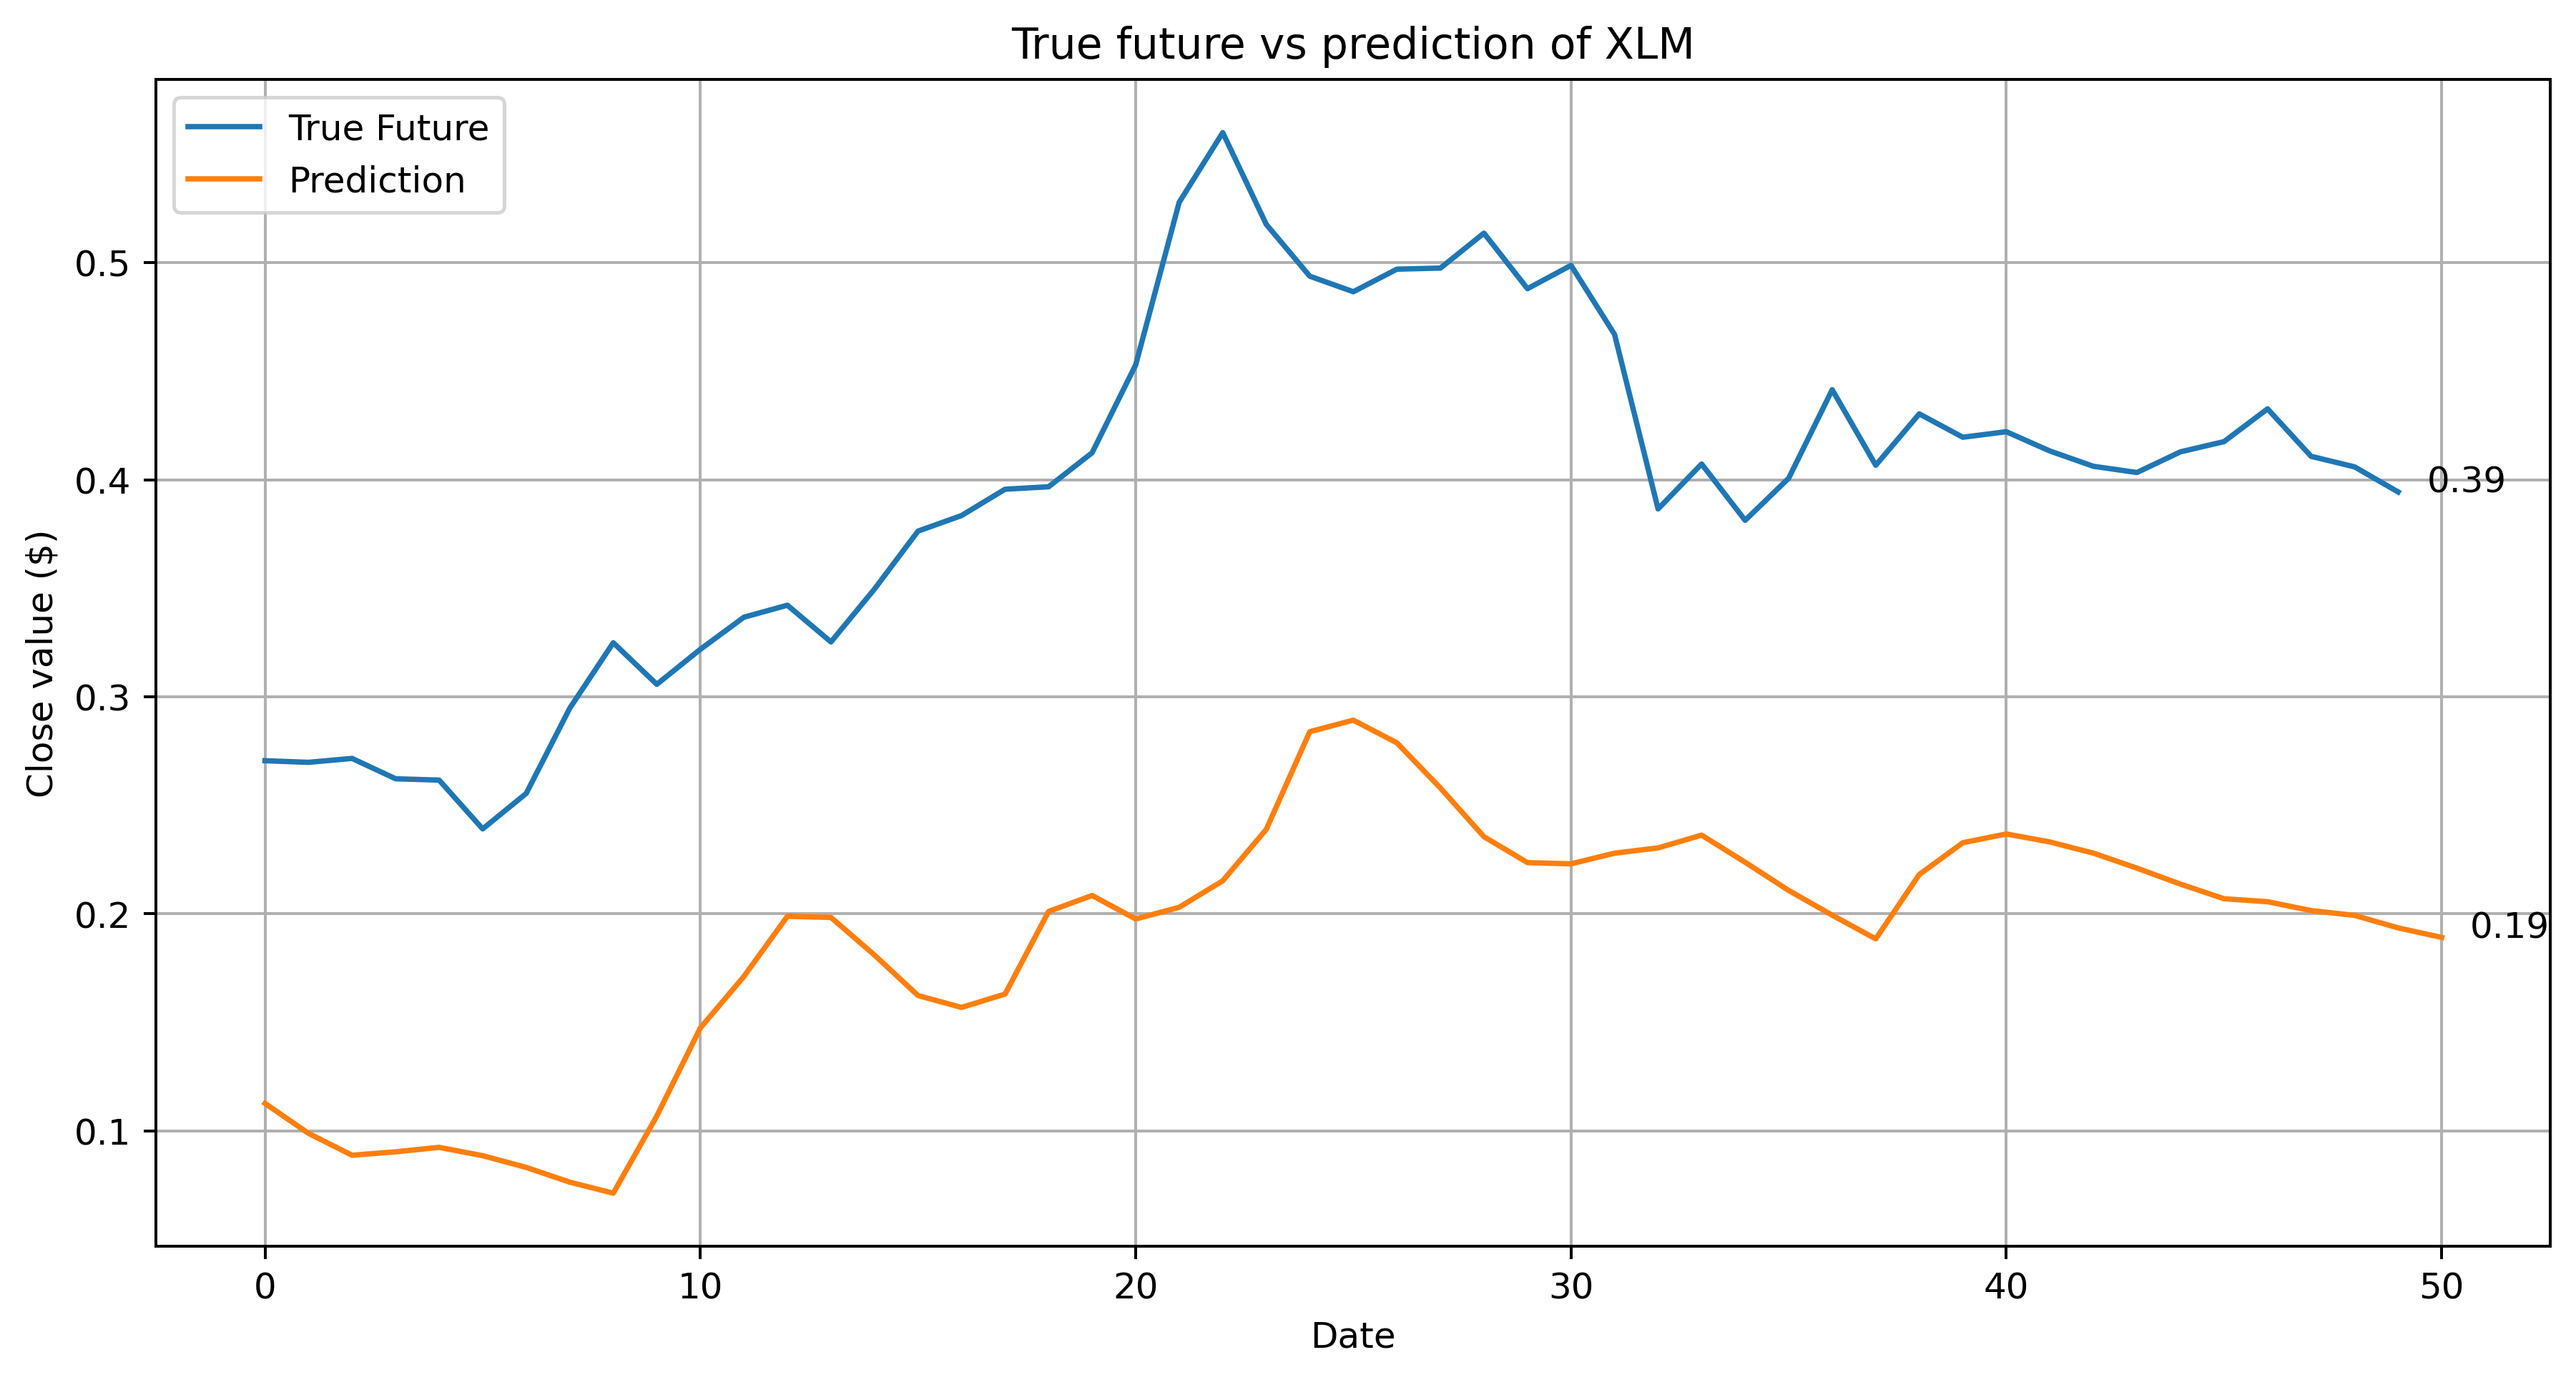

In [19]:
start_date = end_date-timedelta(days=2*TIME_STEPS)
end_date = date.today()

recent_info = getData(currencies, start_date, end_date)
recent_info = recent_info.drop(columns=['Date'])

prediction = forecast(recent_info, TIME_STEPS)


plt.figure(figsize = (12, 6))
plt.rcParams['figure.dpi'] = 360

l0 = np.array(y_test[-TIME_STEPS:])
l1 = np.array(prediction)
fig0 = plt.plot(range(0,TIME_STEPS), l0, label='True Future')
fig1 = plt.plot(range(0,TIME_STEPS+1), l1, label='Prediction')

# Plot values
plt.annotate('%0.2f' % l0[-1], xy=(TIME_STEPS-1, l0[-1]), xytext=(8, 0), 
              xycoords=('data', 'data'), textcoords='offset points')
plt.annotate('%0.2f' % l1[-1], xy=(TIME_STEPS, l1[-1]), xytext=(8, 0), 
              xycoords=('data', 'data'), textcoords='offset points')

plt.title('True future vs prediction of ' + CRYPTO)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Close value ($)')
plt.grid()
plt.show()

## Print trend info

In [20]:
if (prediction[-1] - prediction[-2]>0.1*prediction[-2]):
  print(CRYPTO + " is increasing in value!")
elif (prediction[-1] - prediction[-2]<-(0.1*prediction[-2])):
  print(CRYPTO + " is decreasing in value!")
elif (prediction[-1] - prediction[-2]> 0):
  print(CRYPTO + " is minorly increasing in value")
else:
  print(CRYPTO + " is minorly decreasing in value")
print("Predicted value is: " + str(prediction[-1]) + " and previous predicted value is: " + str(prediction[-2]))

XLM is minorly decreasing in value
Predicted value is: [0.18906572] and previous predicted value is: [0.19347039]


| Date\Crypto | BTC            | BTC-Actual | BCH            | BCH-Actual | ETH            | ETH-Actual | LTC            | LTC-Actual | XLM            | XLM-Actual |
|-------------|----------------|------------|----------------|------------|----------------|------------|----------------|------------|----------------|------------|
| 12-03-2021  | Minor Increase |            | Minor Decrease |            | Minor Decrease |            | Minor Increase |            | Minor Decrease |            |
| 13-03-2021  |                |            |                |            |                |            |                |            |                |            |